In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter

import sys
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
from tqdm import tqdm
import viz_2d as viz
import cd
import score_funcs
import bandpass_filter
plt.style.use('dark_background')

# load the model and dset

In [8]:
# load the dataset
sys.path.append('../dsets/mnist')
import dset
from model import Net
im_torch, im_orig, label = dset.get_im_and_label(251, device=device) # this will download the mnist dataset


# load the model
model = Net().to(device)
model.load_state_dict(torch.load('../dsets/mnist/mnist.model', map_location=device))
model = model.eval()

# generate different amounts of blur

In [9]:
import util 
t = util.Transforms()

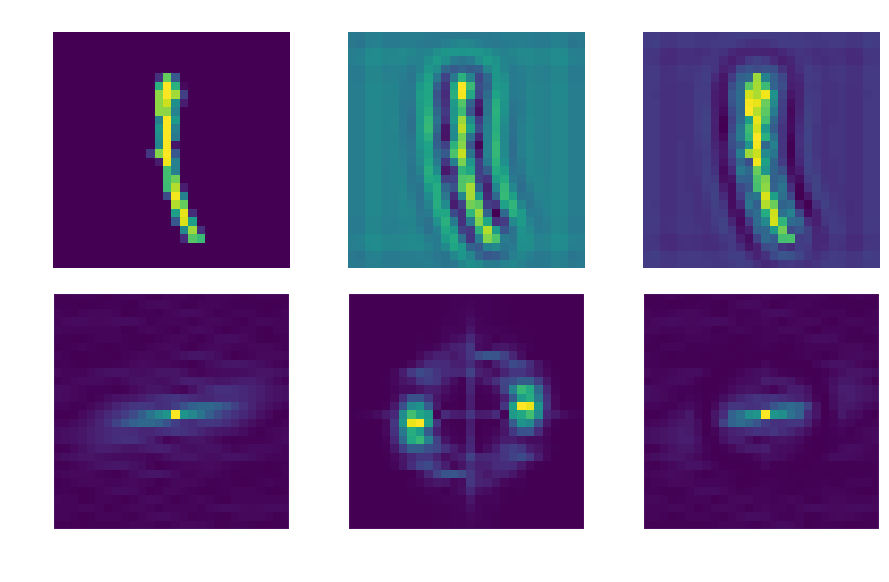

In [10]:
t.sigma = 5e-1
# t.sigma = 1e-9
# transform = t.gaussian_filter
# transform = t.bandpass_filter_approx
transform = t.bandpass_filter
util.visualize(im_orig, transform)

# test response of scores / predictions

**both pred and score monotonically decreases as we lose higher frequencies**

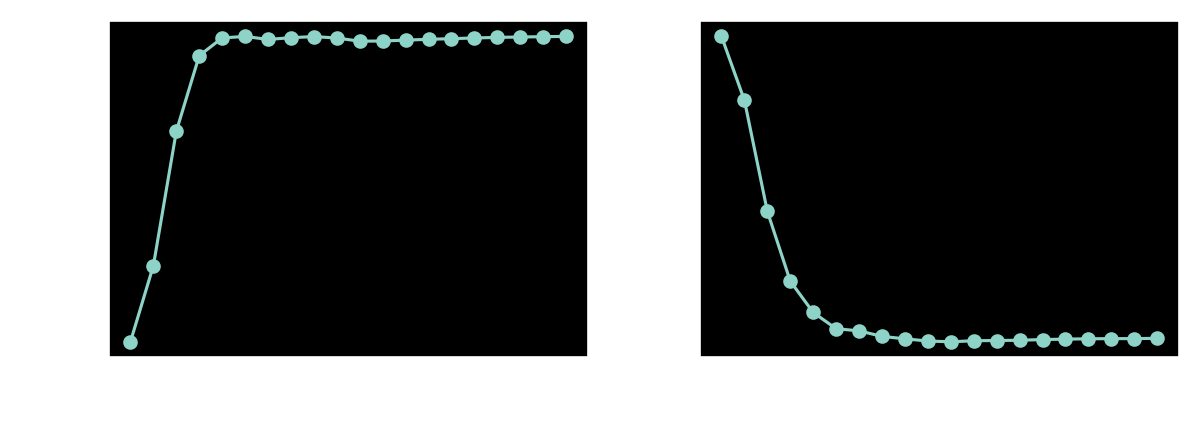

In [11]:
class_num = 4
scores = []
scores_cd = []
sigmas = np.linspace(1e-1, 10, 20) #np.array([1, 1.5, 2, 2.5, 3.5, 5, 7.5])
for sigma in sigmas:
    t.sigma = sigma
    pred = model(t.gaussian_filter(im_torch).to(device)).flatten()[class_num].item()
    scores.append(pred)
    
    score_cd = cd.cd(im_torch, model, mask=None, model_type='mnist', 
                  device='cuda', transform=t.gaussian_filter)[0].flatten()[class_num].item()
    scores_cd.append(score_cd)
    
# plot
plt.figure(dpi=150, figsize=(12, 3))
R, C = 1, 3
plt.subplot(R, C, 1)
plt.plot(sigmas, scores, 'o-')
plt.xlabel('sigma for gaussian')
plt.ylabel('prediction')

plt.subplot(R, C, 2)
plt.plot(sigmas, scores_cd, 'o-')
plt.xlabel('sigma for gaussian')
# plt.xscale('log')
plt.ylabel('cd score')
plt.tight_layout()
plt.show()    

**important freqs are around sigma=1**

100%|██████████| 120/120 [00:01<00:00, 72.69it/s]


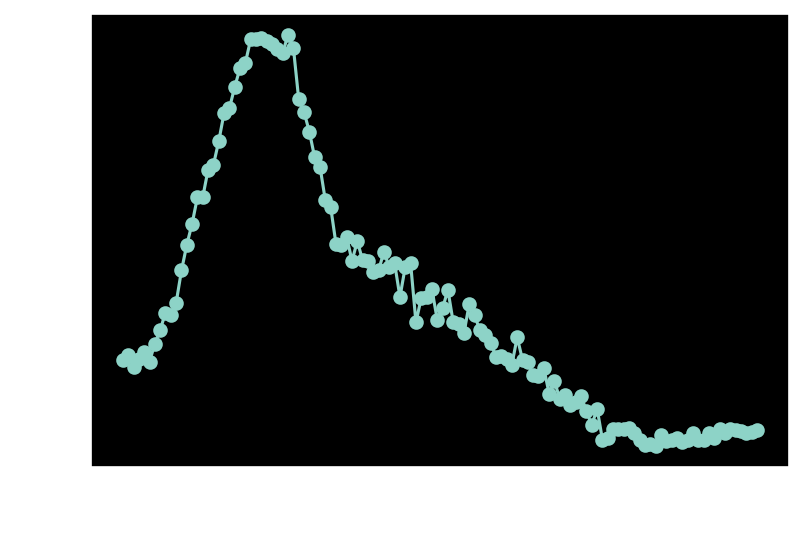

In [12]:
# transform = t.bandpass_filter_approx
transform = t.bandpass_filter
class_num = 4
scores = []
sigmas = np.linspace(0.11, 0.89, 120)
for sigma in tqdm(sigmas):
    t.sigma = sigma
    score = cd.cd(im_torch, model, mask=None, model_type='mnist', 
          device='cuda', transform=transform)[0].flatten()[class_num].item()
    scores.append(score)
    
# plot
plt.figure(dpi=150)
plt.plot(sigmas, scores, 'o-')
plt.xlabel('frequency band $\pm 0.1$')
# plt.xscale('log')
plt.ylabel('cd score')
plt.show()    